Nick Clifford

# Create Tables from `.txt` files 

Now that each document has been scraped and partially cleaned, I will import each one to a dataframe in order to create the `LIB`, `VOCAB`, & `TOKEN` tables. 

# Setup

In [229]:
OHCO = ['doc_id', 'page_num', 'para_num', 'sent_num', 'token_num']

datadir_orig = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/orig/'
datadir_mod = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/mod/'
table_out = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/tables/'

In [280]:
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import nltk
import re

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/nickclifford/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Chunk 
Extract, and clean meaningful text from all data files. Then chunk according to OHCO with paragraph being the highest resolution grouping. Creates the `LIB` and `DOC` tables. 

In [5]:
def get_tables(file_list, OHCO=OHCO):
    """From a list of .txt file names, create both a LIB and DOC table"""
    my_lib = []
    my_doc = []

    for file in tqdm(file_list, unit='file'):
        # Get Doc ID from file name
        doc_id = file.split('/')[-1].split('.')[0]

        lines = open(file, 'r').readlines()
        df = pd.DataFrame(lines, columns=['para_str'])
        df.index.name = 'para_num'
        df.para_str = df.para_str.str.strip()
        df['doc_id'] = doc_id

        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.para_str = df.para_str.str.replace('—', ' — ')
        df.para_str = df.para_str.str.replace('- -', ' - ')
        df.para_str = df.para_str.str.replace('--', ' - ')
        df.para_str = df.para_str.str.replace('&', 'and')

        doc_author = df.para_str[0]
        
        try:
            doc_county = df.para_str[1].split()[0]
        except IndexError:
            doc_county = 'Other'
            
        doc_date = df.para_str[2]
        if len(doc_date.split()) == 3:
            if len(doc_date.split()[1]) <= 2:
                if len(doc_date.split()[2]) == 4:
                    pass
        else:
            doc_date = 'None'
                    
        # Remove cruft
        df = df.iloc[9:] # Remove heading
        #df = df.iloc[12:] # Remove heading & salutation

        # Chunk by page
        page_lines = df.para_str.str.match(re.compile('\[page\s\d\]'))
        page_nums = [i+2 for i in range(df.loc[page_lines].shape[0])]
        df.loc[page_lines, 'page_num'] = page_nums
        df.page_num = df.page_num.ffill()
        df.page_num[pd.isnull(df.page_num)] = 1.0

        # Clean up
        df = df[~page_lines] # Remove chapter heading lines
        df['page_num'] = df['page_num'].astype('int') # turn page_num float to int
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

        # Set index
        df['doc_id'] = doc_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((doc_id, doc_county, doc_author, doc_date))
        my_doc.append(df)
        
    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['doc_id', 'county', 'author', 'date']).set_index('doc_id')
    # convert date column to datetime objects
    library['date'] = pd.to_datetime(library.date.replace('None', np.nan), errors='coerce')
    # remove annotations/keep unclear/added text (Ex: "[unclear: hello]" -> "hello")
    docs['para_str'] = docs.para_str.str\
    .replace('\[illeg\.?|\[deleted:[^\]]*|\[added:\s(?=[^\]]*)|\[unclear:\s(?=[^\]]*)|\]\s?', 
             '', regex=True)
    
    return library, docs

In [6]:
file_list = [file for file in sorted(glob(datadir_mod+'/*.txt'))]
LIB, DOC = get_tables(file_list)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
LIB.sample(10)

,county,author,date
doc_id,,,
A8042,Augusta,W. J. D. Bell,1860-04-21
A0310,Augusta,James R. McCutchan,1862-03-17
A6236,Augusta,William L. Evans,1868-11-10
A6503,Augusta,A. D. Robertson,1865-03-18
A2003,Augusta,William B. Gallaher,1861-05-29
A7150,Augusta,John Scott,1869-03-08
A6091,Augusta,William S. Hopkins,1864-08-02
A9908,Augusta,John D. Imboden,1870-11-26
F0642,Franklin,Augustus Hover,1864-06-15


In [8]:
DOC.sample(10)

,,,para_str
doc_id,page_num,para_num,
A6095,1,17,Emily Hull
A7649,2,18,matters up. I suppose the Sheriffhas not been ...
A3028,3,23,"direction. If this is so, you may expect to he..."
A0011,2,27,Va
A6032,1,13,I will endeavor to write you a few lines once ...
F0029,1,27,Our hospital duties are very light not very ma...
A7173,1,37,Total . . . . . . . . . . . . . . . . . . . . ...
A7162,1,21,"3rd Before much could be done, many of the peo..."
A6517,5,33,the patience to read even this much.


# Tokenize

Use NLTK to tokenize the `DOC` table into a `TOKEN` table. Creates fields for:
- Sentence number 
- Token number/string/part of speech

In [9]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    tqdm.pandas(desc='Paras -> Sents',unit='paragraph')
    df = doc_df.para_str\
        .progress_apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
    tqdm.pandas(desc='Sents -> Tokens', unit='sentence')
    df = df.sent_str\
        .progress_apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    tqdm.pandas(desc='PoS Matching', unit='token')
    df['pos'] = df.pos_tuple.progress_apply(lambda x: x[1])
    tqdm.pandas(desc='Retrieving Tokens', unit='token')
    df['token_str'] = df.pos_tuple.progress_apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [10]:
TOKEN = tokenize(DOC, ws=False)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [11]:
TOKEN.head(10)

pos_tuple  pos token_str
doc_id page_num para_num sent_num token_num                               
A0001  1        9        0        0               (He, PRP)  PRP        He
                                  1              (Qrs, NNP)  NNP       Qrs
                                  2                  (., .)    .         .
                         1        0          (Military, JJ)   JJ  Military
                                  1            (Court, NNP)  NNP     Court
                                  2                  (,, ,)    ,         ,
                                  3               (1st, CD)   CD       1st
                                  4                  (., .)    .         .
                         2        0            (Corps, NNP)  NNP     Corps
                                  1                  (,, ,)    ,         ,

# Vocabulary
Reduce the `TOKEN` table into a `VOCAB` table. Also remove non-word token/terms Creates fields for:
- Term ID/string/frequency
- Dummy variable for number

In [213]:
# lowercase and remove nonword characters, include in term_str/id fields
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
# filter out nonword characters
TOKEN = TOKEN[TOKEN.term_str != '']

In [214]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')
# clean out null values
VOCAB = VOCAB[~VOCAB.term_str.isna()]

Add term_id key to `TOKEN` table in order to combine `TOKEN` and `VOCAB`

In [215]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
TOKEN = TOKEN[~TOKEN.term_str.isna()]

In [216]:
TOKEN.head()

pos_tuple  pos token_str  \
doc_id page_num para_num sent_num token_num                                  
A0001  1        9        0        0               (He, PRP)  PRP        He   
                                  1              (Qrs, NNP)  NNP       Qrs   
                         1        0          (Military, JJ)   JJ  Military   
                                  1            (Court, NNP)  NNP     Court   
                                  3               (1st, CD)   CD       1st   

                                             term_str  term_id stem_porter  
doc_id page_num para_num sent_num token_num                                 
A0001  1        9        0        0                he    10290          he  
                                  1               qrs    17261          qr  
                         1        0          military    14109    militari  
                                  1             court     5413       court  
                                  3               1st      226         1st

In [217]:
VOCAB.head()

,term_str,n,num
term_id,,,
0,0,11,1
1,00,45,1
2,000,1,1
3,09,1,1
4,1,217,1


## Annotate `VOCAB` Table
For each term add : 
- Stopword dummy
- Stem 
- Most common part of speech 
- Rank
- Marginal/prior probability 'p'
- Entropy
- TFIDF sum

### Stopwords
Dummy variable for whether a term is a stopword or not

In [218]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [219]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [220]:
VOCAB[VOCAB.stop == 1].sample(10)

,term_str,n,num,stop
term_id,,,,
15570,over,919,0,1
9182,further,112,0,1
22978,very,3479,0,1
15343,on,4901,0,1
11706,into,555,0,1
2593,below,102,0,1
15265,off,729,0,1
15532,ours,64,0,1
6821,doing,294,0,1


### Stems
Exclude the snowball and lancaster stemmers

In [221]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

In [222]:
VOCAB.sample(5)

,term_str,n,num,stop,stem_porter
term_id,,,,,
9578,gonto,1,0,0,gonto
16428,pliable,1,0,0,pliabl
22354,txxxxxxx,1,0,0,txxxxxxx
14158,miners,4,0,0,miner
1147,alabamers,1,0,0,alabam


### Most Common POS

In [223]:
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1)

In [224]:
VOCAB.sample(3)

,term_str,n,num,stop,stem_porter,pos_max
term_id,,,,,,
23670,wiht,1,0,0,wiht,JJ
13309,magill,1,0,0,magil,NNP
2855,blew,8,0,0,blew,VBD


### Rank

To avoid assigning different ranks to words with the same frequency, this measure groups words by term count.

In [225]:
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank', 'index':'n', 'n':'nn'})\
    .set_index('n')
VOCAB['term_rank'] = VOCAB.n.map(new_rank.term_rank) + 1

In [226]:
VOCAB.sample(3)

,term_str,n,num,stop,stem_porter,pos_max,term_rank
term_id,,,,,,,
16094,perplexing,2,0,0,perplex,NN,553
16377,plastering,1,0,0,plaster,VBG,554
3283,britches,1,0,0,britch,NNS,554


### Probabilities
- p = frequentist probability 
- p2 = marginal probability

In [227]:
VOCAB['p'] = VOCAB.n / VOCAB.shape[0]
VOCAB['p2'] = VOCAB.n / VOCAB.n.sum()

### Entropy

In [231]:
VOCAB['h'] = VOCAB.p2 * np.log2(1/VOCAB.p2) # Self entropy of each word 
H = VOCAB.h.sum()
N_v = VOCAB.shape[0]
H_max = np.log2(N_v)
R = round(1 - (H/H_max), 2) * 100
print("H \t= {}\nH_max \t= {}\nR \t= {}%".format(H, H_max, int(R)))

H 	= 9.32364465010821
H_max 	= 14.561228269251567
R 	= 36%


# Import to `.CSV`

In [232]:
# For Original Text 
#LIB.to_csv(table_out + 'LIB_orig.csv')
#TOKEN.to_csv(table_out + 'TOKEN_orig.csv')
#VOCAB.to_csv(table_out + 'VOCAB_orig.csv')

# For Modernized Spelling
LIB.to_csv(table_out + 'LIB_mod.csv')
TOKEN.to_csv(table_out + 'TOKEN_mod.csv')
VOCAB.to_csv(table_out + 'VOCAB_mod.csv')

# Analysis

In [276]:
sns.set(style='ticks')
%matplotlib inline

## Authors

In [399]:
print('Average number of letters per author: %d\n' %LIB.author.value_counts().mean())

prom_auth = LIB.author.value_counts()[LIB.author.value_counts() >= 7]
print('Most prominent authors (7 or more letters)')
print(prom_auth)

Average number of letters per author: 3

Most prominent authors (7 or more letters)
Jedediah Hotchkiss               187
John Scott                        71
David H. Evans                    53
Alexander K. McClure              51
John Quincy Adams Nadenbousch     47
Mary Anna Sibert                  44
David Demus                       41
Samuel M. Potter                  31
Franklin Rosenbery                29
William F. Brand                  29
John D. Imboden                   26
Thomas M. Smiley                  26
Tony Pastor                       23
Bob Taggart                       22
Adam Wise Kersh                   22
Henry H. Dedrick                  19
Edward McPherson                  18
Samuel Franklin Carson            17
Christian Geisel                  17
Jacob Kent Langhorne              16
E.                                15
William Brand                     15
John P. Dull                      14
Mary A. Smiley                    14
Peter Boyer                 

In [430]:
LIB.shape

(1841, 3)

In [434]:
print("Percentage of prominent authors vs total unique authors: %.2f" %(100*prom_auth.count() / len(LIB.author.unique())))
print("Percentage of prominent author works vs total documents: %.2f" %(100*prom_auth.sum() / LIB.shape[0]))

Percentage of prominent authors vs total unique authors: 9.43
Percentage of prominent author works vs total documents: 59.42 


In [402]:
print("Percentage of prominent authors "prom_auth.sum() / LIB.shape[0])

0.5942422596414992

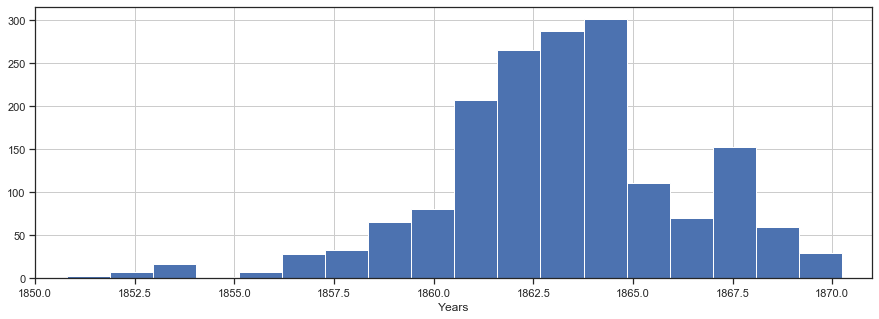

In [377]:
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Years')
LIB.date.dt.year.hist(ax=ax, bins=100)
plt.xlim(1850, 1871)
plt.show()

## County
Distribution of letters per County

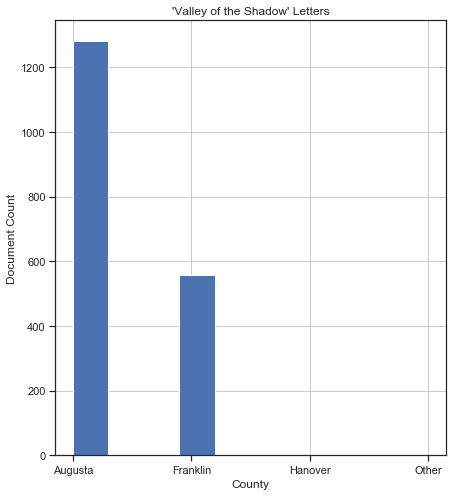

In [398]:
fig, ax = plt.subplots(figsize = (7,8))
plt.xlabel('County')
plt.ylabel('Document Count')
plt.title('\'Valley of the Shadow\' Letters')
LIB.county.hist(ax=ax)
plt.show()

## Terms

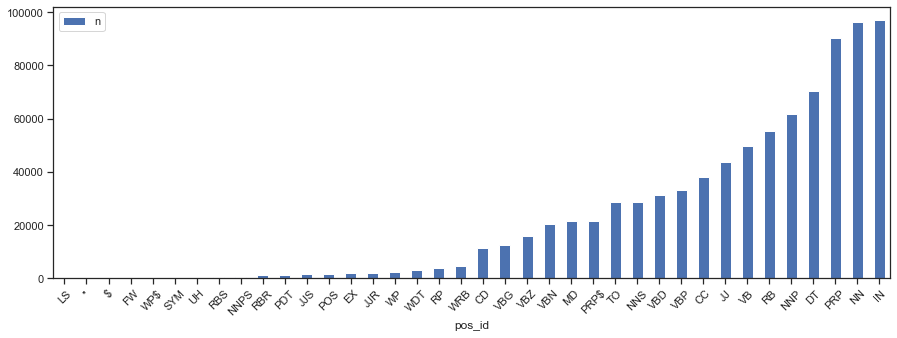

In [367]:
POS = TOKEN.pos.value_counts().to_frame().rename(columns={'pos':'n'})
POS.index.name = 'pos_id'
POS.sort_values('n').plot.bar(y='n', figsize=(15,5), rot=45);

Might be better to remove the salutations from all text ('Dear ---,')

In [365]:
print('Most frequent pronouns: ')
VOCAB[['n','term_str']][VOCAB.pos_max == 'NNP'].sort_values('n', ascending=False)[0:30]

Most frequent pronouns: 


,n,term_str
term_id,,
5913,2452,dear
14551,1336,mr
3681,1045,camp
12035,819,john
9539,793,god
20493,668,staunton
9334,564,general
23079,496,virginia
14236,464,miss


Can expect many infrequent terms to just be incorrectly spelled words

In [394]:
print('Least frequent terms: ')
VOCAB.query('n == 1').sample(10)

Least frequent terms: 


,term_str,n,num,stop,stem_porter,pos_max,term_rank,p,p2,h
term_id,,,,,,,,,,
13676,mccallum,1,0,0,mccallum,NNP,554,0.000041,0.000001,0.000023
2226,ballords,1,0,0,ballord,NNP,554,0.000041,0.000001,0.000023
16018,pennsylvaina,1,0,0,pennsylvaina,NNP,554,0.000041,0.000001,0.000023
10940,humility,1,0,0,humil,NNP,554,0.000041,0.000001,0.000023
11922,janie,1,0,0,jani,NNP,554,0.000041,0.000001,0.000023
14883,newness,1,0,0,new,NN,554,0.000041,0.000001,0.000023
22573,unfortuate,1,0,0,unfortu,JJ,554,0.000041,0.000001,0.000023
6342,determinded,1,0,0,determind,VBN,554,0.000041,0.000001,0.000023
23996,writme,1,0,0,writm,NNP,554,0.000041,0.000001,0.000023


In [380]:
print('Most frequent nouns: ')
VOCAB[['n','term_str']][VOCAB.pos_max == 'NN'].sort_values('n', ascending=False)[0:30]

Most frequent nouns: 


,n,term_str
term_id,,
21815,2816,time
12728,2412,letter
10708,2283,home
13148,2108,love
5876,1716,day
14921,1044,night
14446,975,morning
24075,804,yesterday
23412,775,week


Visualize Zipf's Law

In [381]:
VSAMP1 = VOCAB[['n','term_rank','term_str','pos_max']]

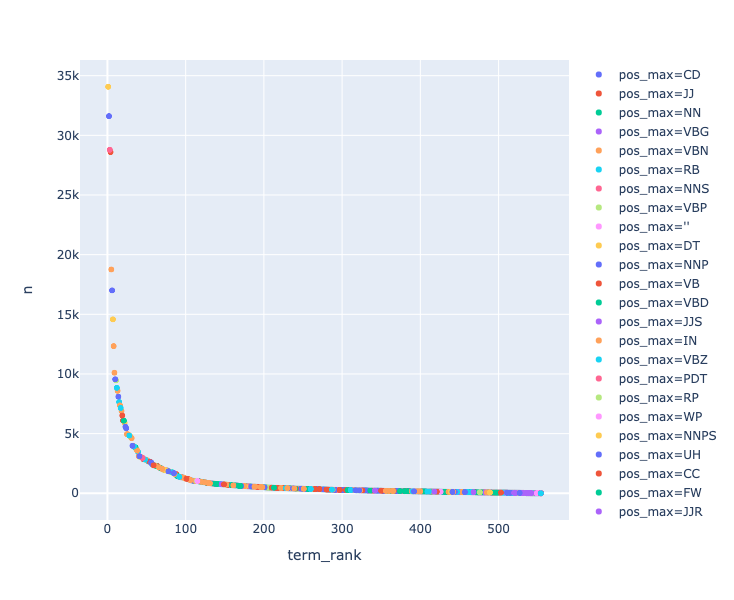

In [382]:
px.scatter(VSAMP1, x='term_rank', y='n', log_y=False, log_x=False, hover_name='term_str', color='pos_max')

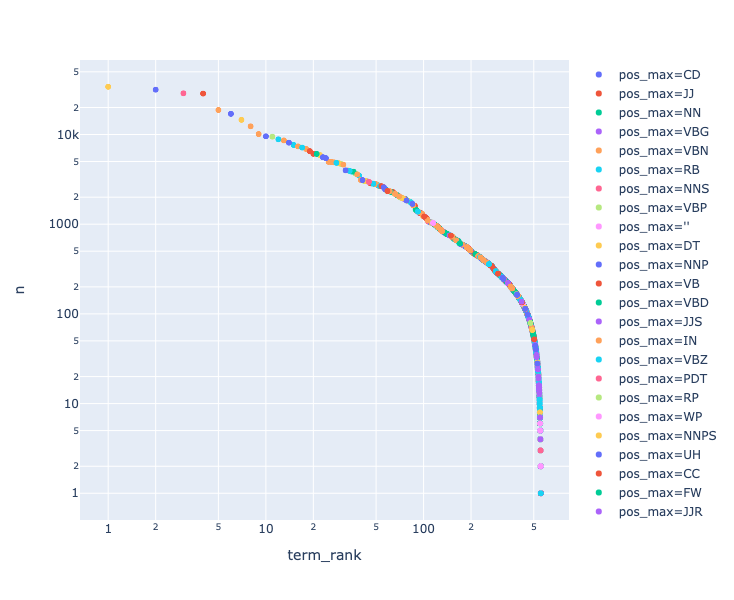

In [383]:
px.scatter(VSAMP1, x='term_rank', y='n', log_y=True, log_x=True, hover_name='term_str', color='pos_max')